In [619]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [620]:
# load files to pandas df and parse dates
users = pd.read_csv('takehome_users.csv', parse_dates=[1,5])
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=[0])

In [621]:
# convert last_session_creation_time colum to datetime from unix time
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [622]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [623]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [624]:
eng_by_user = engagement.groupby('user_id')['visited'].sum()
eng_by_user = eng_by_user.sort_values(ascending=False).reset_index()
eng_by_user.columns = ['user_id', 'total_visits']
eng_by_user.head(10)

,user_id,total_visits
0,3623,606
1,906,600
2,1811,593
3,7590,590
4,8068,585
5,9402,581
6,4022,580
7,3269,566
8,9312,547
9,7210,545


In [625]:
eng_by_user.total_visits.sum()

207917L

In [626]:
active_users = eng_by_user[eng_by_user.total_visits >=3]
active_users.shape

(2248, 2)

In [627]:
eng_split = engagement.sort_values(by = 'time_stamp').reset_index(drop=True)
eng_split.shape

(207917, 3)

In [628]:
# perform 50/50 split at row 103958
eng_train = eng_split.iloc[:103958, :]
eng_test = eng_split.iloc[103958:, :]
print eng_train.shape, eng_test.shape

(103958, 3) (103959, 3)


In [629]:
print eng_train.time_stamp.min()
print eng_train.time_stamp.max()

2012-05-31 08:20:06
2013-12-03 06:37:19


In [630]:
print eng_test.time_stamp.min()
print eng_test.time_stamp.max()

2013-12-03 06:38:34
2014-06-06 14:58:50


In [631]:
import datetime as dt

In [632]:
eng_train = eng_train.groupby('user_id')['time_stamp'].apply(lambda x: list(x))
eng_train = eng_train.reset_index()
eng_train.head()

,user_id,time_stamp
0,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04]"
1,3,[2013-03-19 23:14:52]
2,4,[2013-05-22 08:09:28]
3,5,[2013-01-22 10:14:20]
4,7,[2012-12-20 13:24:32]


In [633]:
# function to filter the 'adopted users' based on the conditions specified: 3 logins on 3 separate days over one 7-day period
# function models a very close approximation to these conditions based on the timedalta between 3 consecutive logins
def active(tsl):
    act_list = []
    for x in range(2,len(tsl)):
        diff1 = (tsl[x] - tsl[x-1])
        diff2 = (tsl[x-1] - tsl[x-2])
        diff3 = (tsl[x] - tsl[x-2])
        c1 = (diff1 >= np.timedelta64(12, 'h')) and (diff1 <= np.timedelta64(36, 'h'))
        c2 = (diff2 >= np.timedelta64(12, 'h')) and (diff2 <= np.timedelta64(36, 'h'))
        c3 = (diff3 < np.timedelta64(8, 'D'))
        conditions = (c1, c2, c3)
        act_list.append(all(conditions))
    return any(act_list)

In [634]:
def second_login(tsl):
    if len(tsl) > 1:
        x = (tsl[1] - tsl[0]) / np.timedelta64(1, 'D')
    else: 
        x = 100000
    return x

In [635]:
eng_train['second_login'] = eng_train['time_stamp'].apply(lambda x: second_login(x))

In [636]:
# identify adopted users in training set
eng_train['adopted_user'] = eng_train['time_stamp'].apply(lambda x: active(x))
eng_train.shape

(5823, 4)

In [637]:
adopted_users_train = eng_train[eng_train['adopted_user'] == True]
adopted_users_train = adopted_users_train.drop('time_stamp', axis=1)
adopted_users_train.shape

(795, 3)

In [638]:
sources = {'ORG_INVITE':1, 'GUEST_INVITE': 2, 'PERSONAL_PROJECTS':3, 'SIGNUP':4, 'SIGNUP_GOOGLE_AUTH':4}

In [639]:
users['creation_source'] = users['creation_source'].apply(lambda x: sources.get(x))
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2,2013-01-22 10:14:20,0,0,193,5240.0


In [640]:
users_train = users.merge(eng_train, how='inner', left_on = 'object_id', right_on = 'user_id')
users_train.shape

(5823, 14)

In [641]:
users_train = users_train.drop(['user_id', 'time_stamp'], axis=1)

In [642]:
users_train['adopted_user'] = pd.to_numeric(users_train['adopted_user'], downcast='integer').fillna(value=0)

In [643]:
time_cutoff = max(eng_train.time_stamp)[0]
type(time_cutoff)

pandas._libs.tslib.Timestamp

In [644]:
users_train.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,second_login,adopted_user
0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0,14.0,False
1,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0,100000.0,False
2,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2,2013-05-22 08:09:28,0,0,1,5151.0,100000.0,False
3,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2,2013-01-22 10:14:20,0,0,193,5240.0,100000.0,False
4,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,4,2012-12-20 13:24:32,0,1,37,NaN,100000.0,False


In [645]:
users_train['creation_time'] = users_train['creation_time'].apply(lambda x: ((time_cutoff - x) / np.timedelta64(1,'D')))

In [646]:
users_train = users_train.drop(['name', 'email', 'last_session_creation_time'], axis=1)

In [647]:
users_train['invited_by_user_id'] = users_train['invited_by_user_id'].fillna(value=0)

In [648]:
X_train = users_train.iloc[:,1:-1].values
X_train.shape

(5823L, 7L)

In [649]:
y_train = users_train.iloc[:,-1].values
y_train.shape

(5823L,)

In [650]:
y_train

array([False, False, False, ..., False, False, False], dtype=bool)

The most important features are:
- time when account was created (calculated in terms of days, the earlier it was created, the higher the number of days)
- the user's organization / company
- who invited the user to join

We can now visualize how these features relate to users becoming adapted users.


In [651]:
eng_test = eng_test.groupby('user_id')['time_stamp'].apply(lambda x: list(x))
eng_test = eng_test.reset_index()
eng_test.head()

,user_id,time_stamp
0,1,[2014-04-22 03:53:30]
1,2,"[2013-12-09 03:45:04, 2013-12-25 03:45:04, 201..."
2,6,[2013-12-19 03:37:06]
3,10,"[2013-12-03 22:08:03, 2013-12-06 22:08:03, 201..."
4,11,[2013-12-27 03:55:54]


In [694]:
eng_test['second_login'] = eng_test['time_stamp'].apply(lambda x: second_login(x))

In [695]:
eng_test['adopted_user'] = eng_test['time_stamp'].apply(lambda x: active(x))
eng_test.shape

(4034, 4)

In [696]:
adopted_users_test = eng_test[eng_test['adopted_user'] == True]
adopted_users_test = adopted_users_test.drop('time_stamp', axis=1)
adopted_users_test.shape

(1096, 3)

In [697]:
already_included = set(users_train['object_id'])
len(already_included)

5823

In [698]:
users_to_drop = []
for user in adopted_users_test['user_id']:
    if user in already_included:
        users_to_drop.append(user)
        
len(users_to_drop)

915

In [699]:
users_test = users.merge(eng_test, how='outer', left_on = 'object_id', right_on = 'user_id')
users_test = users_test.set_index('object_id')
users_test = users_test.drop(already_included, axis=0)
users_test.shape

(6177, 13)

In [700]:
time_cutoff1 = users_test['last_session_creation_time'].max()
time_cutoff1

Timestamp('2014-06-06 14:58:50')

In [701]:
users_test['creation_time'] = users_test['creation_time'].apply(lambda x: ((time_cutoff1 - x) / np.timedelta64(1,'D')))

In [702]:
users_test = users_test.reset_index()
users_test = users_test.drop(['name', 'email', 'last_session_creation_time', 'time_stamp', 'user_id'], axis=1)
users_test['invited_by_user_id'] = users_test['invited_by_user_id'].fillna(value=0)
users_test['adopted_user'] = users_test['adopted_user'].fillna(value=False)
users_test.head()

,object_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,second_login,adopted_user
0,1,45.462037,2,1,0,11,10803.0,100000.0,False
1,6,171.473426,2,0,0,197,11241.0,100000.0,False
2,8,310.392222,3,1,1,74,0.0,NaN,False
3,9,213.454468,3,0,0,302,0.0,NaN,False
4,11,162.460370,4,0,0,69,0.0,100000.0,False


In [703]:
users_test['second_login'] = users_test['second_login'].fillna(value = 10000)

In [704]:
users_train.head(10)

,object_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,second_login,adopted_user
0,2,17.911898,1,0,0,1,316.0,14.0,False
1,3,258.099537,1,0,0,94,1525.0,100000.0,False
2,4,195.728287,2,0,0,1,5151.0,100000.0,False
3,5,319.641574,2,0,0,193,5240.0,100000.0,False
4,7,351.509491,4,0,1,37,0.0,100000.0,False
5,10,320.145938,1,1,1,318,4143.0,6.0,True
6,14,417.391424,4,0,0,0,0.0,100000.0,False
7,19,192.445556,4,1,0,0,0.0,5.0,False
8,21,314.548958,3,0,0,54,0.0,100000.0,False
9,23,472.713715,1,1,0,6,23.0,100000.0,False


In [705]:
users_test['adopted_user'].sum()

181

In [706]:
X_train = users_train.iloc[:,1:-1].values
X_train = np.nan_to_num(X_train)
X_train.shape

(5823L, 7L)

In [707]:
X_test = users_test.iloc[:,1:-1].values
X_test = np.nan_to_num(X_test)
X_test.shape

(6177L, 7L)

In [708]:
y_train = users_train.iloc[:,-1].values
y_train

array([False, False, False, ..., False, False, False], dtype=bool)

In [709]:
y_test = users_test.iloc[:,-1].values
y_test

array([False, False, False, ..., False, False, False], dtype=bool)

In [710]:
print np.isnan(X_train).sum(), np.isinf(X_train).sum(), np.max(X_train)
print np.isnan(X_test).sum(), np.isinf(X_test).sum(), np.max(X_test)

0 0 100000.0
0 0 100000.0


In [711]:
from sklearn.ensemble import RandomForestClassifier

In [712]:
from sklearn.metrics import precision_score, recall_score

In [713]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 100, min_samples_leaf = 1)
rfc = rfc.fit(X_train, y_train)
train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)
y_pred = rfc.predict(X_test)
print "Trining score: ", train_score
print "Test score: ", test_score
print "Precision: ", precision_score(y_test, y_pred)
print "Recall: ", recall_score(y_test, y_pred)

Trining score:  1.0
Test score:  0.968593168205
Precision:  0.41095890411
Recall:  0.165745856354


In [714]:
# create a table of features and feature importance
fl = list(rfc.feature_importances_)
feats = list(users_train.columns[1:-1])
feat_imp = pd.DataFrame(zip(feats, fl))
feat_imp.columns = ['feature', 'feature_importance']
feat_imp

,feature,feature_importance
0,creation_time,0.213425
1,creation_source,0.024867
2,opted_in_to_mailing_list,0.012504
3,enabled_for_marketing_drip,0.009850
4,org_id,0.150519
5,invited_by_user_id,0.086745
6,second_login,0.502090


In [715]:
from sklearn.neural_network import MLPClassifier

In [716]:
mlp = MLPClassifier()
mlp = mlp.fit(X_train, y_train)
train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)
y_pred = mlp.predict(X_test)
print "Trining score: ", train_score
print "Test score: ", test_score
print "Precision: ", precision_score(y_test, y_pred)
print "Recall: ", recall_score(y_test, y_pred)

Trining score:  0.868796153186
Test score:  0.958394042415
Precision:  0.291208791209
Recall:  0.292817679558


In [721]:
print y_train.sum() / float(len(y_train))
print y_test.sum() / float(len(y_test))

0.136527563112
0.0293022502833


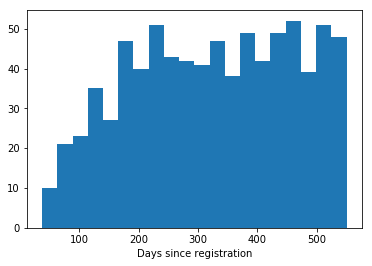

In [726]:
ctime1 = users_train[users_train.adopted_user==True]['creation_time']
plt.hist(ctime1, bins=20)
plt.xlabel('Days since registration')
plt.show()

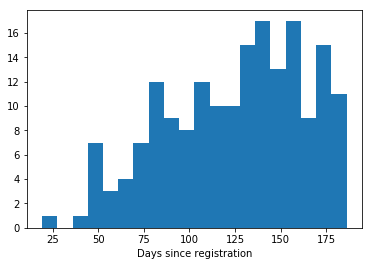

In [727]:
ctime2 = users_test[users_test.adopted_user==True]['creation_time']
plt.hist(ctime2, bins=20)
plt.xlabel('Days since registration')
plt.show()

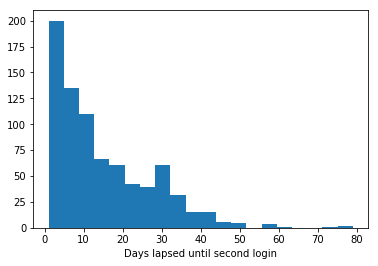

In [728]:
secondlog1 = users_train[users_train.adopted_user==True]['second_login']
plt.hist(secondlog1, bins=20)
plt.xlabel('Days lapsed until second login')
plt.show()

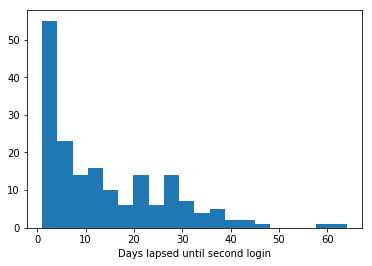

In [729]:
secondlog2 = users_test[users_test.adopted_user==True]['second_login']
plt.hist(secondlog2, bins=20)
plt.xlabel('Days lapsed until second login')
plt.show()